# Loading data & Defining Model

In [5]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import scipy

In [6]:
# load data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# filter out 3 and 7
train_mask = np.isin(train_labels, [3, 7]) #check labels for 3 and 7
test_mask = np.isin(test_labels, [3, 7])
train_images, train_labels = train_images[train_mask], train_labels[train_mask] #filter out images with indices corresponding to 3 and 7
test_images, test_labels = test_images[test_mask], test_labels[test_mask]

# flatten image into 1D vector and normalize pixel values [0,255] -> [0,1]
train_images = train_images.reshape((-1, 28*28)) / 255.0
test_images = test_images.reshape((-1, 28*28)) / 255.0

# convert 3 and 7 labels to binary labels: 3->0, 7->1 so that the logisitic regression can learn them
train_labels = np.where(train_labels == 3, 0, 1)
test_labels = np.where(test_labels == 3, 0, 1)

# split training data randomly into training and validation sets
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)
train_size = int(0.8 * len(indices))
train_indices, val_indices = indices[:train_size], indices[train_size:]

X_train, X_val = train_images[train_indices], train_images[val_indices]
y_train, y_val = train_labels[train_indices], train_labels[val_indices]

# append 1 to every image for the bias term
X_train_bias     = np.c_[np.ones(X_train.shape[0]), X_train]
X_val_bias       = np.c_[np.ones(X_val.shape[0]), X_val]
test_images_bias = np.c_[np.ones(test_images.shape[0]), test_images]

11490434/11490434 [==============================] - 0s 0us/step


### Helper functions for the logisitic regression learning

In [46]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

def cost_function(w, X, t):
    y = sigma(X @ w)
    return -np.mean(t * np.log(y) + (1 - t) * np.log(1 - y))

def compute_gradient(w, X, t):
    y = sigma(X @ w)
    return (y - t) @ X / len(X) # return gradient

def compute_Hessian(w, X):
    N = len(X)                # number of samples
    y = sigma(X @ w)
    A = np.diag(y * (1 - y))  # diagonal matrix of shape (N, N) with y_n(1 - y_n) on the diagonal
    return (X.T @ A @ X) / N  # return Hessain matrix

def compute_Hessian_weight_decay(w,X,lam,d):
    N = len(X)                # number of samples
    y = sigma(X @ w)
    A = np.diag(y * (1 - y))  # diagonal matrix of shape (N, N) with y_n(1 - y_n) on the diagonal
    return (X.T @ A @ X) / N + (lam/(d)) * np.identity(d) # return Hessian matrix with weight decay

def predict(w, X):
    y = sigma(X @ w)
    return np.where(y > 0.5, 1, 0) #return binary labels

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) #return accuracy

def line_search(w, d, X, y):
    cost_fn = lambda gamma: cost_function(w + gamma * d, X, y)
    result = scipy.optimize.minimize_scalar(cost_fn)
    gamma = result.x
    return gamma

The input vector for the logistic regression is a 28x28 flattend image with pixel activations between 0 and 1. Each input vector has a label (3 == 0 or 7 == 1) associated with them. For these first few applications, the problem is to learn the logisitic regression so that it can classify the input vectors correctly, similar to last weeks homework.

In this case we have N = 28x 28 = 784 features, n = 2 classes and P = 9916 training examples. P >> N, so if it were a random problem, we would expect the logisitic regression to fail. However, the data is not random, so we expect the logisitic regression to learn the weights that will classify the data correctly. The output of the logisitic regression is a single value between 0 and 1, which we interpret as the probability that the input vector belongs to class 1. Below we define some functions we will need for all learning methods:

# Gradient Descent

In [ ]:
def logistic_regression_gradient_descent(X_train, y_train, X_val, y_val, eta, max_iterations):
    np.random.seed(42) # set seed for reproducibility
    w = np.random.randn(X_train.shape[1])
    training_errors, validation_errors = [], []
    best_error = np.inf

    for i in range(max_iterations):
        grad = compute_gradient(w, X_train, y_train)
        w = w - eta * grad

        train_error = cost_function(w, X_train, y_train)
        val_error = cost_function(w, X_val, y_val)

        training_errors.append(train_error)
        validation_errors.append(val_error)

        # early stopping mechanism when validation error increases
        if val_error < best_error:
            best_error = val_error
            best_weights = w # ensures that the best weights are returned
        else:
            print(f"Early stopping on iteration {i}")
            return best_weights, training_errors, validation_errors

    return w, training_errors, validation_errors

Accuracy on training set: 99.11%
Accuracy on test set: 98.09%
Error on training set: 0.0282
Error on test set: 0.0750


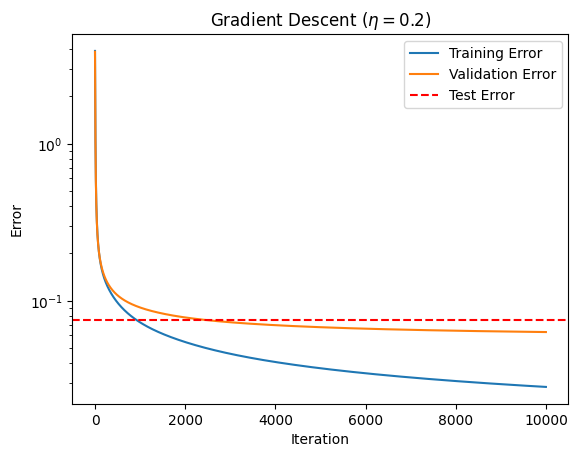

In [ ]:
# initialize parameters
eta = 0.2
max_iterations = 10000

# run gradient descent
w, training_errors, validation_errors = logistic_regression_gradient_descent(X_train_bias, y_train, X_val_bias, y_val, eta, max_iterations)

# compute training and testing accuracies
train_predictions = predict(w, X_train_bias)
train_accuracy    = accuracy(y_train, train_predictions)

test_predictions = predict(w, test_images_bias)
test_accuracy = accuracy(test_labels, test_predictions)
test_error = cost_function(w, test_images_bias, test_labels)

print(f"Accuracy on training set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")
print(f"Error on training set: {training_errors[-1]:.4f}")
print(f"Error on test set: {test_error:.4f}")

# plot results
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.axhline(test_error, color='red', linestyle='--', label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.title(f"Gradient Descent ($\eta={eta})$")
plt.show()

$E_{train} = 0.0280 $  
$E_{test} \ \ = 0.0729$  
Accuracy on train set: 99.12%  
Accuracy on test set: 98.23%  

It takes my CPU 90 seconds to run 10.000 iterations. These results are competitive with the results in the assignment.

# Gradient Descent w/ Momentum

In [ ]:
def logistic_regression_gradient_descent_momentum(X_train, y_train, X_val, y_val, eta, alpha, max_iterations):
    np.random.seed(42) # set seed for reproducibility
    w = np.random.randn(X_train.shape[1])
    v = np.zeros(w.shape)

    training_errors = []
    validation_errors = []
    best_error = np.inf
    best_weights = None

    for i in range(max_iterations):
        gradient = compute_gradient(w, X_train, y_train)

        #update weights and velocity
        v = alpha * v - eta * gradient
        w += v

        train_error = cost_function(w, X_train, y_train)
        val_error = cost_function(w, X_val, y_val)

        training_errors.append(train_error)
        validation_errors.append(val_error)

        # early stopping mechanism when validation error increases
        if val_error < best_error:
            best_error = val_error
            best_weights = w # ensures that the best weights are returned
        else:
            print(f"Early stopping on iteration {i}")
            return best_weights, training_errors, validation_errors

    return w, training_errors, validation_errors

Accuracy on training set: 99.09%
Accuracy on test set: 98.14%
Error on training set: 0.0284
Error on test set: 0.0664


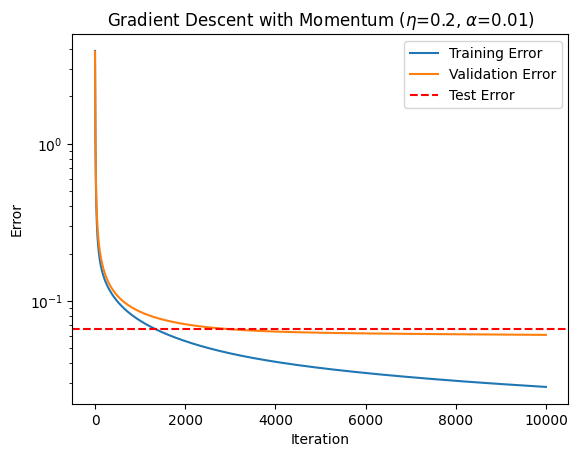

In [ ]:
# initialize parameters
eta = 0.2
alpha = 0.01
max_iterations = 10000

# run gradient descent w/ momentum
w, training_errors, validation_errors = logistic_regression_gradient_descent_momentum(X_train_bias, y_train, X_val_bias, y_val, eta, alpha, max_iterations)

# compute training and testing accuracies
train_predictions = predict(w, X_train_bias)
train_accuracy    = accuracy(y_train, train_predictions)

test_predictions = predict(w, test_images_bias)
test_accuracy = accuracy(test_labels, test_predictions)
test_error = cost_function(w, test_images_bias, test_labels)

print(f"Accuracy on training set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")
print(f"Error on training set: {training_errors[-1]:.4f}")
print(f"Error on test set: {test_error:.4f}")

# plot results
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.axhline(test_error, color='red', linestyle='--', label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.title(f"Gradient Descent with Momentum ($\eta$={eta}, $\\alpha$={alpha})")
plt.show()

$E_{train} = 0.0279 $  
$E_{test} \ \ = 0.0728$  
Accuracy on train set: 99.11%  
Accuracy on test set: 98.28%  

It takes my CPU 90 seconds to run 10.000 iterations. The accuracy on the test set is 0.05% better than without momentum and the results are competitive with the ones in the assignment.

# Gradient Descent w/ Weight Decay


In [ ]:
def logistic_regression_gd_momentum_weight_decay(X_train, y_train, X_val, y_val, eta, alpha, lam, max_iterations):
    np.random.seed(42)
    w = np.random.randn(X_train.shape[1])
    v = np.zeros(w.shape)

    training_errors = []
    validation_errors = []
    best_error = np.inf
    best_weights = None

    d = X_train.shape[1]  #number of features

    for i in range(max_iterations):
        # compute gradient with regularization term
        gradient = compute_gradient(w, X_train, y_train) + (lam/d) * w

        #update weights and velocity
        v = alpha * v - eta * gradient
        w += v
        # compute errors (with the regularization term)
        train_error = cost_function(w, X_train, y_train) + (lam/(2*d)) * np.sum(w**2)
        val_error = cost_function(w, X_val, y_val) + (lam/(2*d)) * np.sum(w**2)

        # store errors (without the regularization term)
        training_errors.append(train_error - (lam/(2*d)) * np.sum(w**2))
        validation_errors.append(val_error - (lam/(2*d)) * np.sum(w**2))

        # early stopping
        if val_error < best_error:
            best_error = val_error
            best_weights = w
        else:
            print(f"Early stopping on iteration {i}")
            return best_weights, training_errors, validation_errors

    return w, training_errors, validation_errors

Accuracy on training set: 99.18%
Accuracy on test set: 98.18%
Error on training set: 0.0283
Error on test set: 0.0635


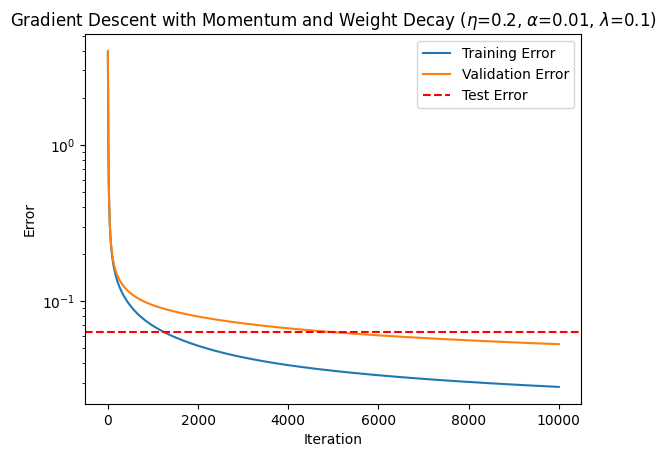

In [ ]:
# initialize parameters
eta = 0.2
alpha = 0.01
lam = 0.1
max_iterations = 10000

# run gradient descent w/ weight decay and momentum
w, training_errors, validation_errors = logistic_regression_gd_momentum_weight_decay(
    X_train_bias, y_train, X_val_bias, y_val, eta, alpha, lam, max_iterations)

# compute training and testing accuracies
train_predictions = predict(w, X_train_bias)
train_accuracy    = accuracy(y_train, train_predictions)

test_predictions = predict(w, test_images_bias)
test_accuracy = accuracy(test_labels, test_predictions)
test_error = cost_function(w, test_images_bias, test_labels)

print(f"Accuracy on training set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")
print(f"Error on training set: {training_errors[-1]:.4f}")
print(f"Error on test set: {test_error:.4f}")

# plot
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.axhline(test_error, color='red', linestyle='--', label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.title(f"Gradient Descent with Momentum and Weight Decay ($\eta$={eta}, $ \\alpha $={alpha}, $\lambda$={lam})")
plt.show()

$E_{train} = 0.0266 $  
$E_{test} \ \ = 0.0634$  
Accuracy on train set: 99.17%  
Accuracy on test set: 98.28%  

It takes my CPU 100 seconds to run 10.000 iterations. These results equally good as the  method with momentum but without weight decay and are competitive with the results in the assignment.

#Newton Method with Weight Decay


In [ ]:
def newton_method_weight_decay(X_train, y_train, X_val, y_val, lam, max_iterations):
    np.random.seed(41)
    w = np.zeros(X_train.shape[1])
    training_errors = []
    validation_errors = []
    best_error = np.inf
    best_weights = None

    d = X_train.shape[1]  #number of features
    for i in range(max_iterations):
        # compute gradient and hessian with the weight decay
        gradient = compute_gradient(w, X_train, y_train) + (lam/d) * w
        hessian = compute_Hessian_weight_decay(w, X_train, lam, d)

        # update weights with newton method
        w = w - np.linalg.inv(hessian)@gradient

        # compute errors (with the regularization term)
        train_error = cost_function(w, X_train, y_train) + (lam/(2*d)) * np.sum(w**2)
        val_error = cost_function(w, X_val, y_val) + (lam/(2*d)) * np.sum(w**2)

        # store errors (without the regularization term)
        training_errors.append(train_error - (lam/(2*d)) * np.sum(w**2))
        validation_errors.append(val_error - (lam/(2*d)) * np.sum(w**2))

        # early stopping
        if val_error < best_error:
            best_error = val_error
            best_weights = w
        else:
            print(f"Early stopping on iteration {i}")
            return best_weights, training_errors, validation_errors

    return w, training_errors, validation_errors

Early stopping on iteration 6
Accuracy on training set: 99.48%
Accuracy on test set: 98.33%
Error on training set: 0.0198
Error on test set: 0.0503


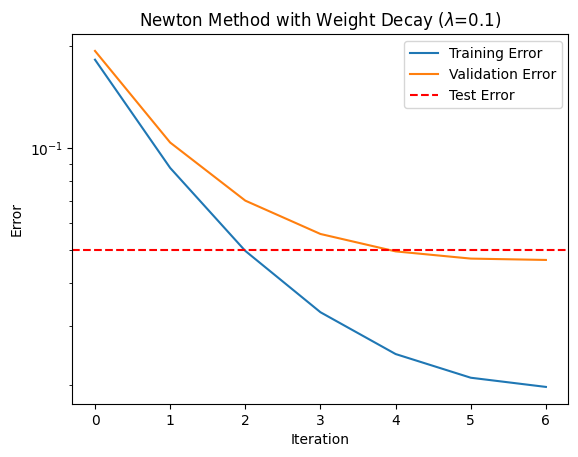

In [ ]:
# initialize parameters
lam = 0.1
max_iterations = 10

# run newton method w/ weight decay
w, training_errors, validation_errors = newton_method_weight_decay(X_train, y_train, X_val, y_val, lam, max_iterations)

# compute training and testing accuracies
train_predictions = predict(w, X_train)
train_accuracy    = accuracy(y_train, train_predictions)

test_predictions = predict(w, test_images)
test_accuracy = accuracy(test_labels, test_predictions)
test_error = cost_function(w, test_images, test_labels)

print(f"Accuracy on training set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")
print(f"Error on training set: {training_errors[-1]:.4f}")
print(f"Error on test set: {test_error:.4f}")

# plot
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.axhline(test_error, color='red', linestyle='--', label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.title(f"Newton Method with Weight Decay ($\lambda$={lam})")
plt.show()

# Line Seach

In [8]:
def new_cost_function(gamma, d, w, X, t):
    eqn = w + d * gamma
    y = sigma(X @ eqn)
    return -np.mean(t * np.log(y) + (1 - t) * np.log(1 - y))

In [9]:
def line_search_algorithm(X_train, y_train, X_val, y_val, max_iterations):

    np.random.seed(50) # set seed for reproducibility
    w = np.random.randn(X_train.shape[1])
    training_errors, validation_errors = [], []
    best_error = np.inf

    for i in range(max_iterations):
        d = -compute_gradient(w, X_train, y_train)
        result = scipy.optimize.minimize(new_cost_function, 0, args=(d, w, X_train, y_train))
        gamma = result.x
        w += gamma*d

        train_error = cost_function(w, X_train, y_train)
        val_error = cost_function(w, X_val, y_val)

        training_errors.append(train_error)
        validation_errors.append(val_error)

        # early stopping mechanism when validation error increases
        if val_error < best_error:
            best_error = val_error
            best_weights = w # ensures that the best weights are returned
        else:
            print(f"Early stopping on iteration {i}")
            return best_weights, training_errors, validation_errors

    return w, training_errors, validation_errors

Early stopping on iteration 64
Accuracy on training set: 98.82%
Accuracy on test set: 97.64%
Error on training set: 0.0402
Error on test set: 0.0738


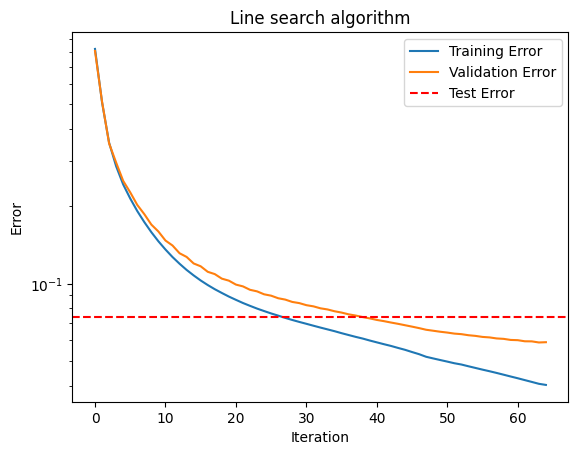

In [10]:
w, training_errors, validation_errors = line_search_algorithm(X_train, y_train, X_val, y_val, 1000)

# compute training and testing accuracies
train_predictions = predict(w, X_train)
train_accuracy    = accuracy(y_train, train_predictions)

test_predictions = predict(w, test_images)
test_accuracy = accuracy(test_labels, test_predictions)
test_error = cost_function(w, test_images, test_labels)

print(f"Accuracy on training set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")
print(f"Error on training set: {training_errors[-1]:.4f}")
print(f"Error on test set: {test_error:.4f}")

# plot
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.axhline(test_error, color='red', linestyle='--', label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.title(f"Line search algorithm")
plt.show()

# Conjugate gradient descent

In [47]:
def conjugate_gradient_descent(X_train, y_train, X_val, y_val, max_iterations):
    np.random.seed(42) # set seed for reproducibility
    w = np.zeros(X_train.shape[1])
    training_errors, validation_errors = [], []
    best_error = np.inf
    grad = compute_gradient(w, X_train, y_train)
    d = -grad


    for i in range(max_iterations):
        gamma = line_search(w, d, X_train, y_train) * 0.1
        w += gamma*d
        grad_new = compute_gradient(w, X_train, y_train)

        # computing beta with the polak-ribiere rule
        dif = grad_new - grad
        beta = np.dot(grad_new, dif) / np.dot(grad, grad)

        grad = grad_new
        d = -grad + beta*d

        train_error = cost_function(w, X_train, y_train)
        val_error = cost_function(w, X_val, y_val)
        # print(f"Iteration {i + 1}: Training Error = {train_error}, Validation Error = {val_error}")

        training_errors.append(train_error)
        validation_errors.append(val_error)

        # early stopping mechanism when validation error increases
        if val_error < best_error:
            best_error = val_error
            best_weights = w # ensures that the best weights are returned
        else:
            print(f"Early stopping on iteration {i}")
            return best_weights, training_errors, validation_errors
    print(w.shape)
    return w, training_errors, validation_errors


Early stopping on iteration 65
Accuracy on training set: 98.83%
Accuracy on test set: 98.04%
Error on training set: 0.0364
Error on test set: 0.0531


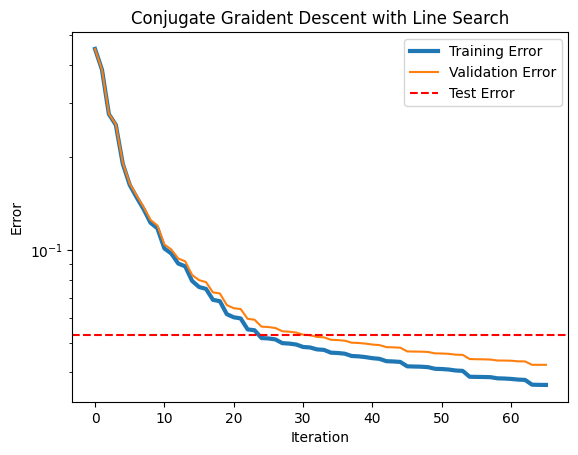

In [48]:
w, training_errors, validation_errors = conjugate_gradient_descent(X_train, y_train, X_val, y_val, 100)

# compute training and testing accuracies
train_predictions = predict(w, X_train)
train_accuracy    = accuracy(y_train, train_predictions)

test_predictions = predict(w, test_images)
test_accuracy = accuracy(test_labels, test_predictions)
test_error = cost_function(w, test_images, test_labels)

print(f"Accuracy on training set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")
print(f"Error on training set: {training_errors[-1]:.4f}")
print(f"Error on test set: {test_error:.4f}")

# plot
plt.plot(training_errors,linewidth=3, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.axhline(test_error, color='red', linestyle='--', label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.title(f"Conjugate Graident Descent with Line Search")
plt.show()

# Stochastic Gradient Descent

In [ ]:
def logistic_regression_sgd(X_train, y_train, X_val, y_val, eta, max_iterations, batch_size):
    np.random.seed(42) # set seed for reproducibility
    w = np.random.randn(X_train.shape[1])
    training_errors, validation_errors = [], [] #

    for i in range(max_iterations):
        # shuffle data for stochasticity
        indices = np.random.permutation(len(X_train))
        X_train = X_train[indices]  #shuffle both images and labels in the same way
        y_train = y_train[indices]

        # iterate over single mini-batch
        batch_start = batch_size
        batch_end = 2 * batch_size
        X_batch = X_train[batch_start:batch_end] #select batch to compute gradient on
        y_batch = y_train[batch_start:batch_end]

        # compute gradient and update weights
        grad = compute_gradient(w, X_batch, y_batch)
        w = w - eta * grad

        # compute & store errors
        train_error = cost_function(w, X_train, y_train)
        val_error = cost_function(w, X_val, y_val)

        training_errors.append(train_error)
        validation_errors.append(val_error)

        # i removed the basic early stopping mechanism because stochastic gradient descent is more noisy and the validation error can fluctuate a lot.

    return w, training_errors, validation_errors

Accuracy on training set: 97.31%
Accuracy on test set: 96.66%
Error on training set: 0.0990
Error on test set: 0.1418


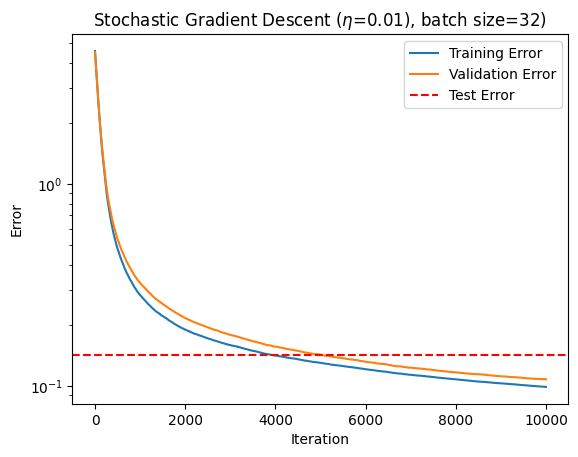

In [ ]:
# initialize parameters
eta = 0.2
max_iterations = 10000
batch_size = 7

# run stochastic gradient descent
w, training_errors, validation_errors = logistic_regression_sgd(X_train_bias, y_train, X_val_bias, y_val, eta, max_iterations, batch_size)

# compute training and testing accuracies
train_predictions = predict(w, X_train_bias)
train_accuracy = accuracy(y_train, train_predictions)

test_predictions = predict(w, test_images_bias)
test_accuracy = accuracy(test_labels, test_predictions)
test_error = cost_function(w, test_images_bias, test_labels)

# print results
print(f"Accuracy on training set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")
print(f"Error on training set: {training_errors[-1]:.4f}")
print(f"Error on test set: {test_error:.4f}")

# plot results
plt.plot(training_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.axhline(test_error, color='red', linestyle='--', label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.title(f"Stochastic Gradient Descent ($\eta$={eta}), batch size={batch_size})")
plt.show()

$E_{train} = 0.0344 $  
$E_{test} \ \ = 0.0694$  
Accuracy on train set: 98.92%  
Accuracy on test set: 98.09%  

It takes my CPU 166 seconds to run 10.000 iterations, which is very different from the 5 seconds mentioned in the assignment. These results are competitive with the results in the assignment though.

# Discussion

We’re assuming n is supposed to be d, since n = 1,…,N.

If there are more samples N, the test error will most likely decrease. A higher N will allow for a larger training set which causes the model to capture more variability and predict the test data more accurately.

With a larger number of variables d there is a higher risk of overfitting to the training data. The training error will therefore decrease, but the test error will most likely be a lot higher.

Also, there are no differences in complexity and data that influences the methods we are using as we are always applying them to the same logistic regression problem and for each model we are trying to find the optimal configuration of weights.

With more variables w the model becomes more complex. If there are not a lot of variables d, then increasing w will allow for better utilizing each variable. If d is sufficiently extensive, then a shallow network could also work well and increasing w would be unnecessary.